## Analysing temperature impacts from anesthesic interventions

Here we create the following scenarios, plotting the temperature impacts:

### Individual intervention types:
To more easily attribute the warming effects of the two relevant interventions to the study, we estimate the total number of historical anesthesic interventions, and create idealised scenarios where all interventions are performed in one of those two methods.
- Sevoflurane only: 
- TIVA only:

## History + future projections:
To inform about the potential warming impacts that different anesthesia interventions may have in the future, we create three idealised scenarios branching off from the historical emissions:
- History plus status quo: we use our estimations for the historical emissions of these compounds (HFE-236ea2, HFE-347mmz1, HCFE-235da2, Halon-2311), and project future emissions as constant based on 2023 figures. These emissions timeseries are defined in `../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv`
- History plus abrupt change to TIVA:
- History plust abrupt change to sevoflurane:




In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill
from fair.io import read_properties
from fair.interface import initialise

# Base scenario to run simulations
scenario_to_compare = "ssp245"

In [2]:
# First, run the base SSP scenario so we have a temperature baseline we can compare against

# Run twin experiment, but without anesthesics
f_no_anesthesics = FAIR()
f_no_anesthesics.define_time(1750, 2500, 1)
scenarios = [scenario_to_compare]
f_no_anesthesics.define_scenarios(scenarios)
fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_no_anesthesics.define_configs(configs)
species_no_anaesthesics, properties_no_anaesthesics = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_original.csv")
f_no_anesthesics.define_species(species_no_anaesthesics, properties_no_anaesthesics)
f_no_anesthesics.allocate()
f_no_anesthesics.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)]
fe = da.expand_dims(dim=["config"], axis=(2))
f_no_anesthesics.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))
f_no_anesthesics.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
initialise(f_no_anesthesics.concentration, f_no_anesthesics.species_configs["baseline_concentration"])
initialise(f_no_anesthesics.forcing, 0)
initialise(f_no_anesthesics.temperature, 0)
initialise(f_no_anesthesics.cumulative_emissions, 0)
initialise(f_no_anesthesics.airborne_emissions, 0)
f_no_anesthesics.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0.csv')

f_no_anesthesics.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_no_anesthesics_temperature = f_no_anesthesics.temperature[:,:,:,0].copy(deep=True).loc[dict(scenario=scenario_to_compare)]
del f_no_anesthesics

Running 841 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

In [48]:
# First experiment: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

f_status_quo = FAIR()
f_status_quo.define_time(1750, 2500, 1)

# scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
scenarios = [scenario_to_compare]
f_status_quo.define_scenarios(scenarios)

# Old simple configs
# configs = ["high", "central", "low"]
# f.define_configs(configs)

fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_status_quo.define_configs(configs)

species, properties = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_status_quo.define_species(species, properties)

f_status_quo.allocate()

f_status_quo.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)

# I was lazy and didn't convert emissions to CSV, so use the old clunky method of importing from netCDF
# this is from calibration-1.4.0
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)] # select which scenarios we are going to run from the emissions data
fe = da.expand_dims(dim=["config"], axis=(2)) #  Create an object with those scenarios for each possible configuration
f_status_quo.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Fill anesthesics
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv")

# Prepare the new emissions
species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1_status_quo = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1_status_quo = emissions_1_status_quo[:, :, np.newaxis]
emissions_1_status_quo = np.repeat(emissions_1_status_quo, len(configs), axis=2)

species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2_status_quo = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2_status_quo = emissions_2_status_quo[:, :, np.newaxis]
emissions_2_status_quo = np.repeat(emissions_2_status_quo, len(configs), axis=2)

species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3_status_quo = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3_status_quo = emissions_3_status_quo[:, :, np.newaxis]
emissions_3_status_quo = np.repeat(emissions_3_status_quo, len(configs), axis=2)

species4_df = anesthesics_df[
    (anesthesics_df["Variable"] == "Halon-2311") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_4_status_quo = species4_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_4_status_quo = emissions_4_status_quo[:, :, np.newaxis]
emissions_4_status_quo = np.repeat(emissions_4_status_quo, len(configs), axis=2)

fill(f_status_quo.emissions, emissions_1_status_quo, specie="HFE-236ea2")
fill(f_status_quo.emissions, emissions_2_status_quo, specie="HFE-347mmz1")
fill(f_status_quo.emissions, emissions_3_status_quo, specie="HCFE-235da2")
fill(f_status_quo.emissions, emissions_4_status_quo, specie="Halon-2311")

# Also include historical emissions associated with TIVA interventions for the last 25 years
# 40.000.000 interventions per annum * 0.56 kg of plastic per interventions * 3.14 kg CO2 from incinerated kg of plastic * 1-12 to convert to GtCO2 = 7.0336e-5 GtCO2
TIVA_emissions_status_quo = np.zeros(750)
TIVA_emissions_status_quo[250:275] = 40000000 * 0.56 * 3.14 * 1e-12

# From then onwards, assume that the same number of interventions are performed with TIVA
TIVA_emissions_status_quo[275:] = 40000000 * 0.56 * 3.14 * 1e-12

f_status_quo.emissions.loc[dict(specie='CO2 FFI')] = f_status_quo.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions_status_quo[:, np.newaxis, np.newaxis]

f_status_quo.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")

# initialising 
initialise(f_status_quo.concentration, f_status_quo.species_configs["baseline_concentration"])
initialise(f_status_quo.forcing, 0)
initialise(f_status_quo.temperature, 0)
initialise(f_status_quo.cumulative_emissions, 0)
initialise(f_status_quo.airborne_emissions, 0)


f_status_quo.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

f_status_quo.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_status_quo_temperature = f_status_quo.temperature[:,:,:,0].copy(deep=True).loc[dict(scenario=scenario_to_compare)]
del f_status_quo

Running 841 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

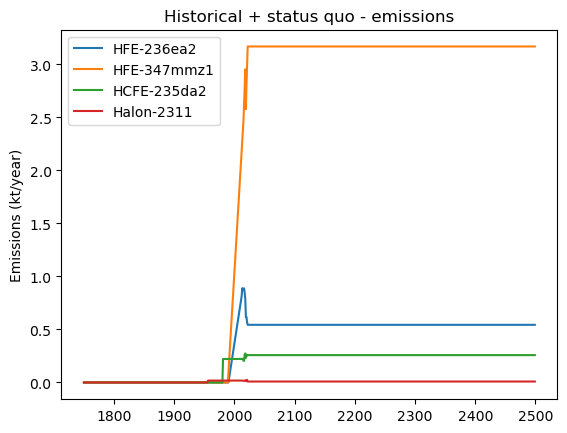

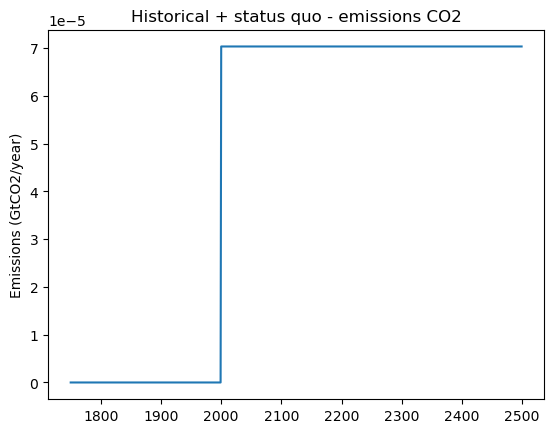

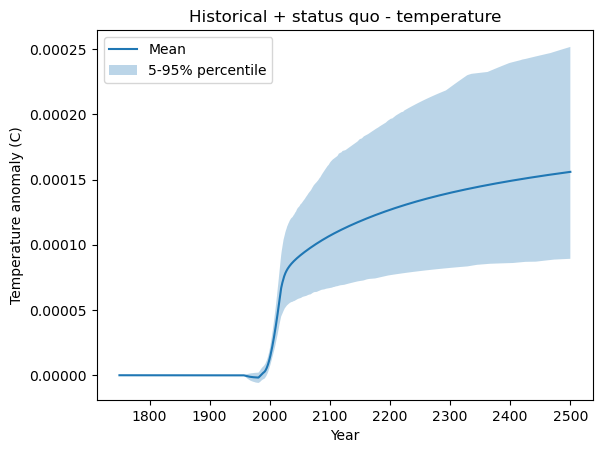

In [49]:
# First experiment plots: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

mean_f_status_quo_temperature = (f_status_quo_temperature - f_no_anesthesics_temperature).mean(dim='config')
p05_f_status_quo_temperature = (f_status_quo_temperature - f_no_anesthesics_temperature).quantile(0.05, dim='config')
p95_f_status_quo_temperature = (f_status_quo_temperature - f_no_anesthesics_temperature).quantile(0.95, dim='config')

# For diagnosis purposes, just plot these emissions timeseries
timebounds = np.arange(1750,2500,1)
timebounds_1 = np.arange(1750,2501,1)
plt.plot(timebounds, emissions_1_status_quo[:, 0, 0], label="HFE-236ea2")
plt.plot(timebounds, emissions_2_status_quo[:, 0, 0], label="HFE-347mmz1")
plt.plot(timebounds, emissions_3_status_quo[:, 0, 0], label="HCFE-235da2")
plt.plot(timebounds, emissions_4_status_quo[:, 0, 0], label="Halon-2311")
plt.title('Historical + status quo - emissions')
plt.ylabel('Emissions (kt/year)')
plt.legend()
plt.show()

plt.plot(timebounds, TIVA_emissions_status_quo)
plt.title('Historical + status quo - emissions CO2')
plt.ylabel('Emissions (GtCO2/year)')
plt.show()

# Plot the mean with a shaded area for 5-95 percentile
plt.plot(timebounds_1, mean_f_status_quo_temperature, label='Mean')
plt.fill_between(timebounds_1, p05_f_status_quo_temperature, p95_f_status_quo_temperature, alpha=0.3, label='5-95% percentile')

plt.title('Historical + status quo - temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (C)')
plt.legend()
plt.show()


In [26]:
# Second experiment: History + only sevoflurane interventions as defined in ../data/emissions/anesthesics_gas_emissions(Sevo only based on Talbot NO adjustment).csv

f_sevo_only = FAIR()
f_sevo_only.define_time(1750, 2500, 1)

# scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
scenarios = [scenario_to_compare]
f_sevo_only.define_scenarios(scenarios)

# Old simple configs
# configs = ["high", "central", "low"]
# f.define_configs(configs)

fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_sevo_only.define_configs(configs)

species, properties = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_sevo_only.define_species(species, properties)

f_sevo_only.allocate()

f_sevo_only.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)

# I was lazy and didn't convert emissions to CSV, so use the old clunky method of importing from netCDF
# this is from calibration-1.4.0
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)] # select which scenarios we are going to run from the emissions data
fe = da.expand_dims(dim=["config"], axis=(2)) #  Create an object with those scenarios for each possible configuration
f_sevo_only.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Fill anesthesics
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions(Sevo only based on Talbot NO adjustment).csv")

# Prepare the new emissions
species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1_sevo_only = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1_sevo_only = emissions_1_sevo_only[:, :, np.newaxis]
emissions_1_sevo_only = np.repeat(emissions_1_sevo_only, len(configs), axis=2)

species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2_sevo_only = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2_sevo_only = emissions_2_sevo_only[:, :, np.newaxis]
emissions_2_sevo_only = np.repeat(emissions_2_sevo_only, len(configs), axis=2)

species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3_sevo_only = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3_sevo_only = emissions_3_sevo_only[:, :, np.newaxis]
emissions_3_sevo_only = np.repeat(emissions_3_sevo_only, len(configs), axis=2)

species4_df = anesthesics_df[
    (anesthesics_df["Variable"] == "Halon-2311") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_4_sevo_only = species4_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_4_sevo_only = emissions_4_sevo_only[:, :, np.newaxis]
emissions_4_sevo_only = np.repeat(emissions_4_sevo_only, len(configs), axis=2)

fill(f_sevo_only.emissions, emissions_1_sevo_only, specie="HFE-236ea2")
fill(f_sevo_only.emissions, emissions_2_sevo_only, specie="HFE-347mmz1")
fill(f_sevo_only.emissions, emissions_3_sevo_only, specie="HCFE-235da2")
fill(f_sevo_only.emissions, emissions_4_sevo_only, specie="Halon-2311")

# Also include historical emissions associated with TIVA interventions for the last 25 years
# 40.000.000 interventions per annum * 0.56 kg of plastic per interventions * 3.14 kg CO2 from incinerated kg of plastic * 1-12 to convert to GtCO2 = 7.0336e-5 GtCO2
TIVA_emissions_sevo_only = np.zeros(750)
TIVA_emissions_sevo_only[250:275] = 40000000 * 0.56 * 3.14 * 1e-12

f_sevo_only.emissions.loc[dict(specie='CO2 FFI')] = f_sevo_only.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions_sevo_only[:, np.newaxis, np.newaxis]

f_sevo_only.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")

# initialising 
initialise(f_sevo_only.concentration, f_sevo_only.species_configs["baseline_concentration"])
initialise(f_sevo_only.forcing, 0)
initialise(f_sevo_only.temperature, 0)
initialise(f_sevo_only.cumulative_emissions, 0)
initialise(f_sevo_only.airborne_emissions, 0)


f_sevo_only.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

f_sevo_only.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_sevo_only_temperature = f_sevo_only.temperature[:,:,:,0].copy(deep=True).loc[dict(scenario=scenario_to_compare)]
del f_sevo_only

Running 841 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

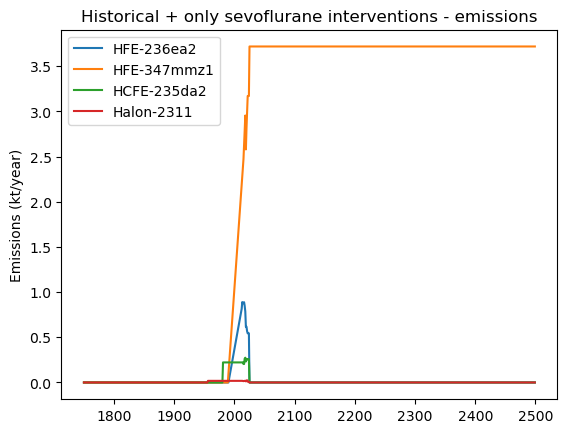

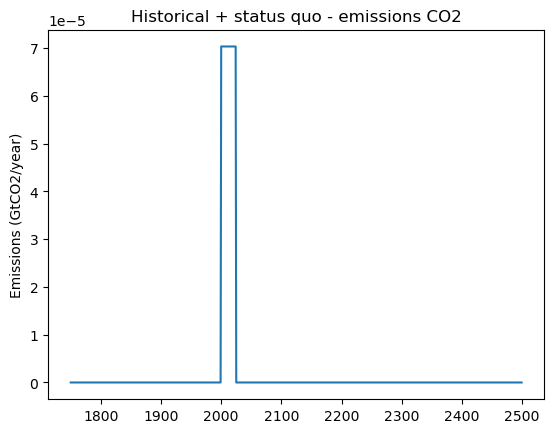

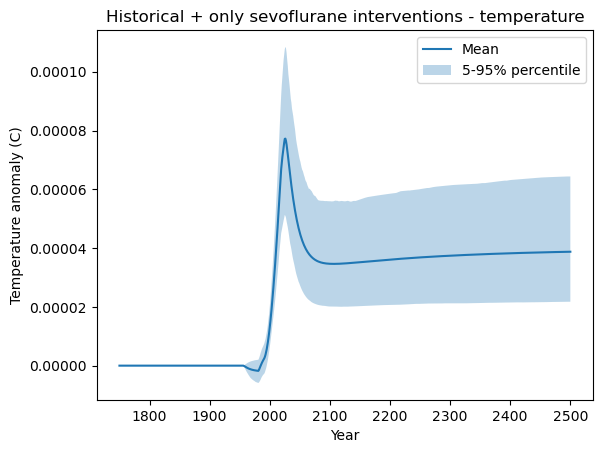

In [ ]:
# Second experiment: History + only sevoflurane interventions as defined in ../data/emissions/anesthesics_gas_emissions(Sevo only based on Talbot NO adjustment).csv

mean_f_sevo_only_temperature = (f_sevo_only_temperature - f_no_anesthesics_temperature).mean(dim='config')
p05_f_sevo_only_temperature = (f_sevo_only_temperature - f_no_anesthesics_temperature).quantile(0.05, dim='config')
p95_f_sevo_only_temperature = (f_sevo_only_temperature - f_no_anesthesics_temperature).quantile(0.95, dim='config')

# For diagnosis purposes, just plot these emissions timeseries
timebounds = np.arange(1750,2500,1)
timebounds_1 = np.arange(1750,2501,1)
plt.plot(timebounds, emissions_1_sevo_only[:, 0, 0], label="HFE-236ea2")
plt.plot(timebounds, emissions_2_sevo_only[:, 0, 0], label="HFE-347mmz1")
plt.plot(timebounds, emissions_3_sevo_only[:, 0, 0], label="HCFE-235da2")
plt.plot(timebounds, emissions_4_sevo_only[:, 0, 0], label="Halon-2311")
plt.title('Historical + only sevoflurane interventions - emissions')
plt.ylabel('Emissions (kt/year)')
plt.legend()
plt.show()

plt.plot(timebounds, TIVA_emissions_sevo_only)
plt.title('Historical + only sevoflurane - emissions CO2')
plt.ylabel('Emissions (GtCO2/year)')
plt.show()

# Plot the mean with a shaded area for 5-95 percentile
plt.plot(timebounds_1, mean_f_sevo_only_temperature, label='Mean')
plt.fill_between(timebounds_1, p05_f_sevo_only_temperature, p95_f_sevo_only_temperature, alpha=0.3, label='5-95% percentile')

plt.title('Historical + only sevoflurane interventions - temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (C)')
plt.legend()
plt.show()


In [51]:
# Third experiment: History + only TIVA interventions - using historical as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

f_tiva_only = FAIR()
f_tiva_only.define_time(1750, 2500, 1)

# scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
scenarios = [scenario_to_compare]
f_tiva_only.define_scenarios(scenarios)

# Old simple configs
# configs = ["high", "central", "low"]
# f.define_configs(configs)

fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_tiva_only.define_configs(configs)

species, properties = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_tiva_only.define_species(species, properties)

f_tiva_only.allocate()

f_tiva_only.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)

# I was lazy and didn't convert emissions to CSV, so use the old clunky method of importing from netCDF
# this is from calibration-1.4.0
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)] # select which scenarios we are going to run from the emissions data
fe = da.expand_dims(dim=["config"], axis=(2)) #  Create an object with those scenarios for each possible configuration
f_tiva_only.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Fill anesthesics
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv")

# Prepare the new emissions
species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1_tiva_only = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1_tiva_only[275:, :] = 0 # Set emissions to zero after 2025
emissions_1_tiva_only = emissions_1_tiva_only[:, :, np.newaxis]
emissions_1_tiva_only = np.repeat(emissions_1_tiva_only, len(configs), axis=2)

species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2_tiva_only = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2_tiva_only[275:, :] = 0 # Set emissions to zero after 2025
emissions_2_tiva_only = emissions_2_tiva_only[:, :, np.newaxis]
emissions_2_tiva_only = np.repeat(emissions_2_tiva_only, len(configs), axis=2)

species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3_tiva_only = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3_tiva_only[275:, :] = 0 # Set emissions to zero after 2025
emissions_3_tiva_only = emissions_3_tiva_only[:, :, np.newaxis]
emissions_3_tiva_only = np.repeat(emissions_3_tiva_only, len(configs), axis=2)

species4_df = anesthesics_df[
    (anesthesics_df["Variable"] == "Halon-2311") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_4_tiva_only = species4_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_4_tiva_only[275:, :] = 0 # Set emissions to zero after 2025
emissions_4_tiva_only = emissions_4_tiva_only[:, :, np.newaxis]
emissions_4_tiva_only = np.repeat(emissions_4_tiva_only, len(configs), axis=2)

fill(f_tiva_only.emissions, emissions_1_tiva_only, specie="HFE-236ea2")
fill(f_tiva_only.emissions, emissions_2_tiva_only, specie="HFE-347mmz1")
fill(f_tiva_only.emissions, emissions_3_tiva_only, specie="HCFE-235da2")
fill(f_tiva_only.emissions, emissions_4_tiva_only, specie="Halon-2311")

# Also include historical emissions associated with TIVA interventions for the last 25 years
# 40.000.000 interventions per annum * 0.56 kg of plastic per interventions * 3.14 kg CO2 from incinerated kg of plastic * 1-12 to convert to GtCO2 = 7.0336e-5 GtCO2
TIVA_emissions_tiva_only = np.zeros(750)
TIVA_emissions_tiva_only[250:275] = 40000000 * 0.56 * 3.14 * 1e-12

# From then onwards, assume that all interventions are performed with TIVA, i.e. 150.000.000 interventions per annum
TIVA_emissions_tiva_only[275:] = 150000000 * 0.56 * 3.14 * 1e-12


f_tiva_only.emissions.loc[dict(specie='CO2 FFI')] = f_tiva_only.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions_tiva_only[:, np.newaxis, np.newaxis]

f_tiva_only.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")

# initialising 
initialise(f_tiva_only.concentration, f_tiva_only.species_configs["baseline_concentration"])
initialise(f_tiva_only.forcing, 0)
initialise(f_tiva_only.temperature, 0)
initialise(f_tiva_only.cumulative_emissions, 0)
initialise(f_tiva_only.airborne_emissions, 0)


f_tiva_only.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

f_tiva_only.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_tiva_only_temperature = f_tiva_only.temperature[:,:,:,0].copy(deep=True).loc[dict(scenario=scenario_to_compare)]
del f_tiva_only

Running 841 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

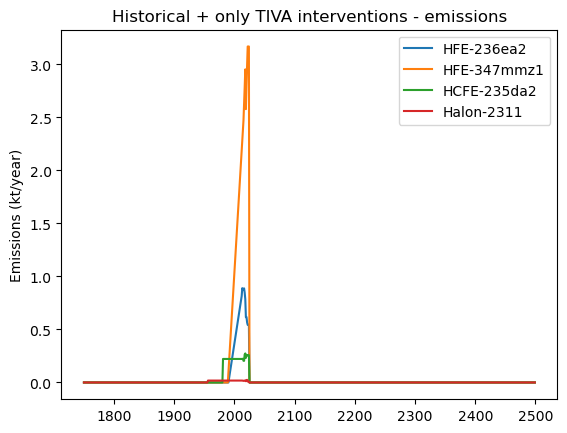

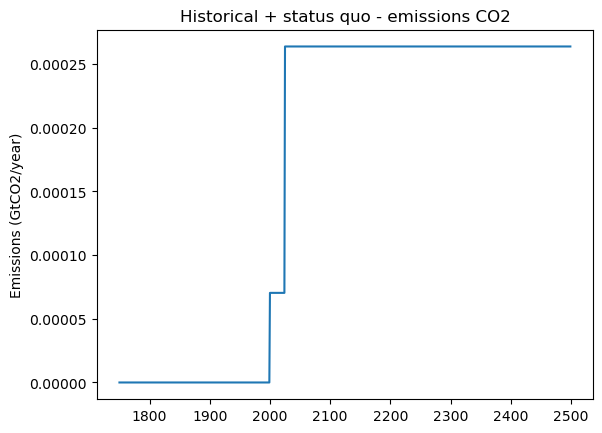

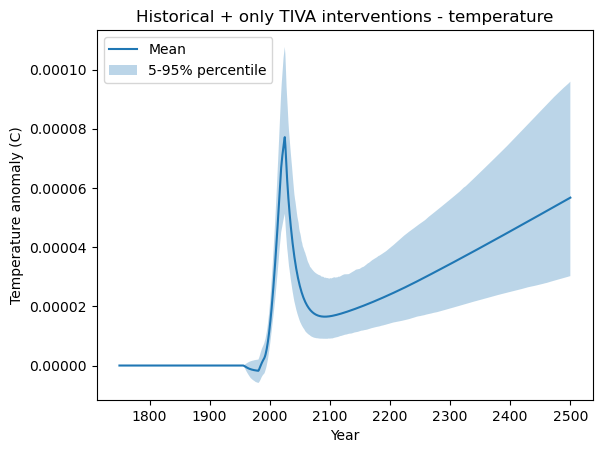

In [ ]:
# Third experiment: History + only TIVA interventions - using historical as defined in../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

mean_f_tiva_only_temperature = (f_tiva_only_temperature - f_no_anesthesics_temperature).mean(dim='config')
p05_f_tiva_only_temperature = (f_tiva_only_temperature - f_no_anesthesics_temperature).quantile(0.05, dim='config')
p95_f_tiva_only_temperature = (f_tiva_only_temperature - f_no_anesthesics_temperature).quantile(0.95, dim='config')

# For diagnosis purposes, just plot these emissions timeseries
timebounds = np.arange(1750,2500,1)
timebounds_1 = np.arange(1750,2501,1)
plt.plot(timebounds, emissions_1_tiva_only[:, 0, 0], label="HFE-236ea2")
plt.plot(timebounds, emissions_2_tiva_only[:, 0, 0], label="HFE-347mmz1")
plt.plot(timebounds, emissions_3_tiva_only[:, 0, 0], label="HCFE-235da2")
plt.plot(timebounds, emissions_4_tiva_only[:, 0, 0], label="Halon-2311")
plt.title('Historical + only TIVA interventions - emissions')
plt.ylabel('Emissions (kt/year)')
plt.legend()
plt.show()

plt.plot(timebounds, TIVA_emissions_tiva_only)
plt.title('Historical + only TIVA - emissions CO2')
plt.ylabel('Emissions (GtCO2/year)')
plt.show()

# Plot the mean with a shaded area for 5-95 percentile
plt.plot(timebounds_1, mean_f_tiva_only_temperature, label='Mean')
plt.fill_between(timebounds_1, p05_f_tiva_only_temperature, p95_f_tiva_only_temperature, alpha=0.3, label='5-95% percentile')

plt.title('Historical + only TIVA interventions - temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (C)')
plt.legend()
plt.show()

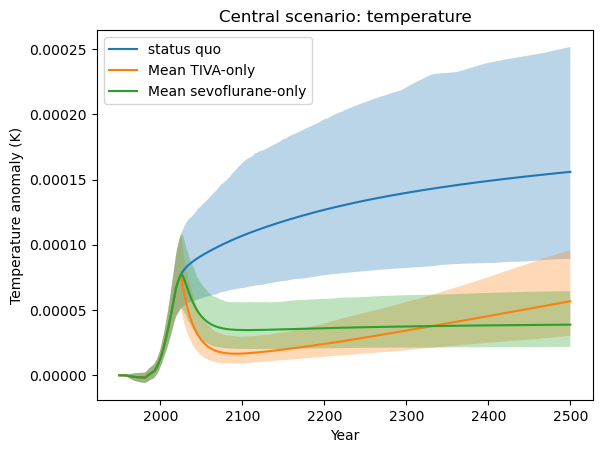

In [ ]:
# No plotting the three scenarios together:
# Status quo
# only sevoflurane
# only TIVA

initial_year = 1950 - 1750

plt.plot(timebounds_1[initial_year:], mean_f_status_quo_temperature[initial_year:], label='Status quo')
plt.fill_between(timebounds_1[initial_year:], p05_f_status_quo_temperature[initial_year:], p95_f_status_quo_temperature[initial_year:], alpha=0.3)

# TIVA abrupt change
plt.plot(timebounds_1[initial_year:], mean_f_tiva_only_temperature[initial_year:], label='TIVA-only')
plt.fill_between(timebounds_1[initial_year:], p05_f_tiva_only_temperature[initial_year:], p95_f_tiva_only_temperature[initial_year:], alpha=0.3)

# TIVA only
plt.plot(timebounds_1[initial_year:], mean_f_sevo_only_temperature[initial_year:], label='Sevoflurane-only')
plt.fill_between(timebounds_1[initial_year:], p05_f_sevo_only_temperature[initial_year:], p95_f_sevo_only_temperature[initial_year:], alpha=0.3)

plt.title('Central scenario: temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (K)')
plt.legend()
plt.show()